In [2]:
# %%
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



### Figure OFC

In [3]:

exp_name = 'ofc_no/OFC_ablation'
var_steps = [0 ,10 ,20, 30, 50,100, 200,300,400, 500] # No of PFC neurons experiemnt
# exp_name = 'time_steps/OFC_ablation'
# var_steps = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200] #time steps experiment
results_folder = './../results/'

#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
exps = {0: 'ofc off', 1: 'ofc2md', 2:'ofc2dlPFC', 3:'mul_off'}

#Isolate and stack change point performance
def get_cp_perf(config, performances, window = 30):
    vtpb = [500] * 8 + [100] * 6
    vt = np.cumsum(vtpb)[np.array(config.ofc_control_schedule[:len(vtpb)])=='on']
    # not using this becomes config files here were saved prior to recent updates and not working, at the moment.
    # vt = np.cumsum(config.variable_trials_per_block)[np.array(config.ofc_control_schedule[:len(config.variable_trials_per_block)])=='on']
    vt = vt[:-1] # exclude last entry, just the end trial
    change_perf = [performance[cp-10:cp+window+10] for cp in vt for performance in performances]
    cp = np.vstack(change_perf)
    return(cp)

def get_performances(exp_to_run,     window = 30, ax=None):
    # vars = [(var1, var2) for var1 in [exp_to_run] for var2 in [0 ,10 ,20, 30, 50,100, 200,300,400, 500]]
    vars = [(var1, var2) for var1 in [exp_to_run] for var2 in var_steps]

    regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
    labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

    means, md_modulations =[], []
    cps = []
    means, stds = [], []
    for label, regex in zip (labels, regexes):
        comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
        conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
        
        if len(comp_files) > 0:
            performances = [np.load(c1f) for c1f in comp_files]
            config = np.load(conf_files[0], allow_pickle=True).item()
            md_modulations.append(config.md_context_modulation)
            cp = get_cp_perf(config, performances, window=window)
            cps.append(cp)
            means.append((cp.mean(0)[10:10+window]).mean())
        
            if not ax is None:
                smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
                sp = np.stack(smooth_performances)
                spmean = np.mean(sp, axis=0)    
                spstd = np.std(sp, axis=0)    
                means.append(spmean)
                stds.append(spstd)
                ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
                ax.legend()
                # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
        else:
            print(f'no files found for {label}')
            means.append(np.nan)
    return (performances, cps, labels)

# plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)




In [15]:
def plot_var_vs_performance(ax):
    exp_to_run =2
    performances, cps , labels = get_performances(exp_to_run, window, None)
    means_dlpfc = [(cp.mean(0)[10:10+window]).mean() for cp in cps]
    means = means_dlpfc
    ax.plot(var_steps, means, 'o', color='grey')
    ax.plot(var_steps, means, label= 'to dlPFC')
    exp_to_run =1
    performances, cps , labels = get_performances(exp_to_run, window, None)
    means_md = [(cp.mean(0)[10:10+window]).mean() for cp in cps]
    means = means_md
    ax.plot(var_steps, means, 'o', color='grey')
    ax.plot(var_steps, means, label='to md')

    # exp_to_run =3
    # performances, cps , labels = get_performances(exp_to_run, window, None)
    # means_mul_off = [(cp.mean(0)[10:10+window]).mean() for cp in cps]
    # means = means_mul_off
    # ax.plot(var_steps, means, 'o', color='grey')
    # ax.plot(var_steps, means, label='mul_off')

    # ax.set_xlim([0, 5])
    ax.legend()
# plt.savefig('./exports/to_md_to_dlpfc_MULOFF_no_dlPFCneurons.jpg', dpi=300)


(0.0, 10.0)

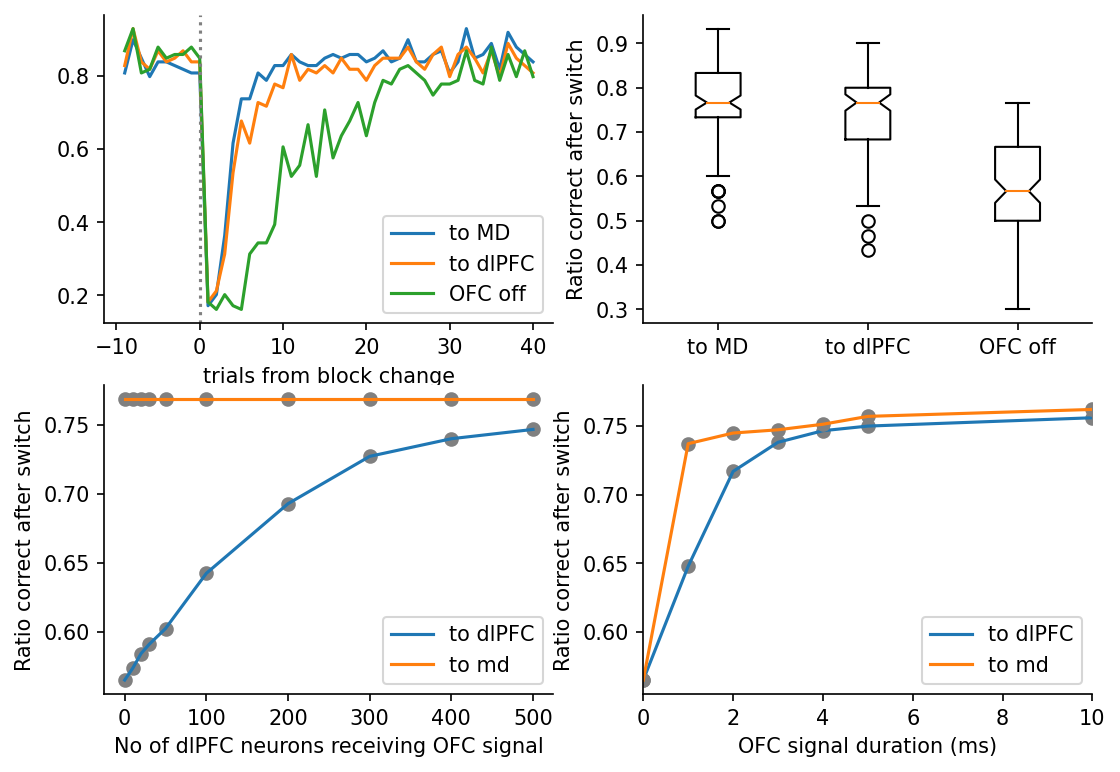

In [16]:
window = 30
fig, axes = plt.subplots(2,2, figsize=[8.5, 6])
ax = axes[0,0]
exp_to_run =1 # To MD
performances, cps , labels = get_performances(exp_to_run, window, None)
cp = cps[-1]
means_md = cp[:, 10:10+window].mean(1)
ax.plot(range(-9, window+11), cp.mean(0) ,label= 'to MD')

exp_to_run =2 # To dlPFC
performances, cps , labels = get_performances(exp_to_run, window, None)
cp = cps[-1]
means_dlpfc = cp[:, 10:10+window].mean(1)
ax.plot(range(-9, window+11), cp.mean(0) , label= 'to dlPFC')

exp_to_run =2 #ofc off
performances, cps , labels = get_performances(exp_to_run, window, None)
cp = cps[0] # cps[0] experiment sends ofc signal to 0 dlPFC neurons
means_no_ofc = cp[:, 10:10+window].mean(1)
ax.plot(range(-9, window+11), cp.mean(0) , label= 'OFC off') 

ax.axvline(0, linestyle=':', color='grey')
ax.legend()
ax.set_xlabel('trials from block change')
ax = axes[0,1]
lls = ['to MD', 'to dlPFC', 'OFC off']
ax.boxplot( [means_md, means_dlpfc, means_no_ofc], notch=True)
ax.get_xticklabels()
ax.set_xticklabels(lls)
# ax.set_title(exps[exp_to_run])
ax.set_ylabel('Ratio correct after switch')
ax = axes[1,0]
exp_name = 'ofc_no/OFC_ablation'
var_steps = [0 ,10 ,20, 30, 50,100, 200,300,400, 500] # No of PFC neurons experiemnt
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
plot_var_vs_performance(ax)
ax.set_ylabel('Ratio correct after switch')
ax.set_xlabel('No of dlPFC neurons receiving OFC signal')

ax = axes[1,1]
exp_name = 'time_steps/OFC_ablation'
var_steps = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
plot_var_vs_performance(ax)
ax.set_xlabel('OFC signal duration (ms)')
ax.set_xlim([0,10])

# plt.savefig('./exports/Figure_ofc.JPG', dpi=300)

In [13]:
ax.set_xticklabels(lls)

[Text(1, 0, 'to MD'), Text(2, 0, 'to dlPFC'), Text(3, 0, 'no OFC')]

In [8]:
# %%
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



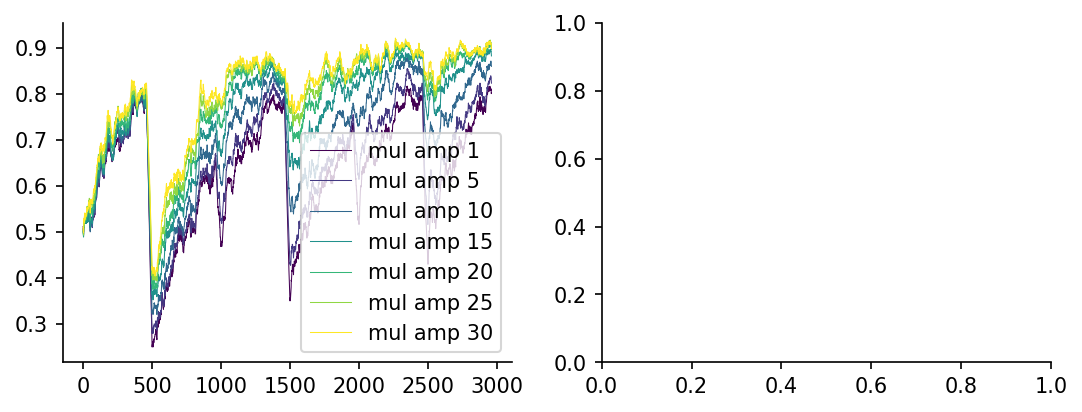

In [23]:
exp_name = 'mul_amp2/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]

regexes = [f"\d_{float(amp):1.1f}_0.0__" for amp in [1, 5, 10, 15, 20, 25, 30]] # 0, 1, 2 ,3,4 ,5, 
labels = [f'mul amp {amp}' for amp in [1, 5, 10, 15, 20, 25, 30]]

import matplotlib
no_of_values = len(labels)
norm = mpl.colors.Normalize(vmin=min([1,no_of_values]), vmax=max([1,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('viridis')
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

fig, axes = plt.subplots(1,2, figsize=[8.5,3])
ax = axes[0]
means, stds = [], []
for i, (label, regex) in enumerate(zip (labels, regexes)):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)] 
    if len(comp_files) > 0:    
        smooth_performances = [np.convolve(np.load(c1f), np.ones((40,))/40, mode='valid') for c1f in comp_files]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5, color=cmap.to_rgba(i+1),)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
plt.savefig(f'./exports/mul_amp_effect.{file_format}', format=file_format, dpi=300)


In [ ]:
def get_trial_rates(id, log):
    return (log.PFCrates[id,:,:])

# log = np.load(results_folder+exp_name+'/' +log_files[2], allow_pickle=True).item() # this is full model with mul oon.
# idx = [2200, 2205, 2803, 2807]
log = np.load(results_folder+exp_name+'/' +log_files[0], allow_pickle=True).item()  # Mul off but still with decent md_context_modulation But look context errors below.
idx = [2200, 2204, 2803, 2805]

t1rates = get_trial_rates(idx[0], log)
t2rates = get_trial_rates(idx[1], log)
t3rates = get_trial_rates(idx[2], log)
t4rates = get_trial_rates(idx[3], log)
print(np.corrcoef(t1rates.reshape(-1), t2rates.reshape(-1))[0,1])


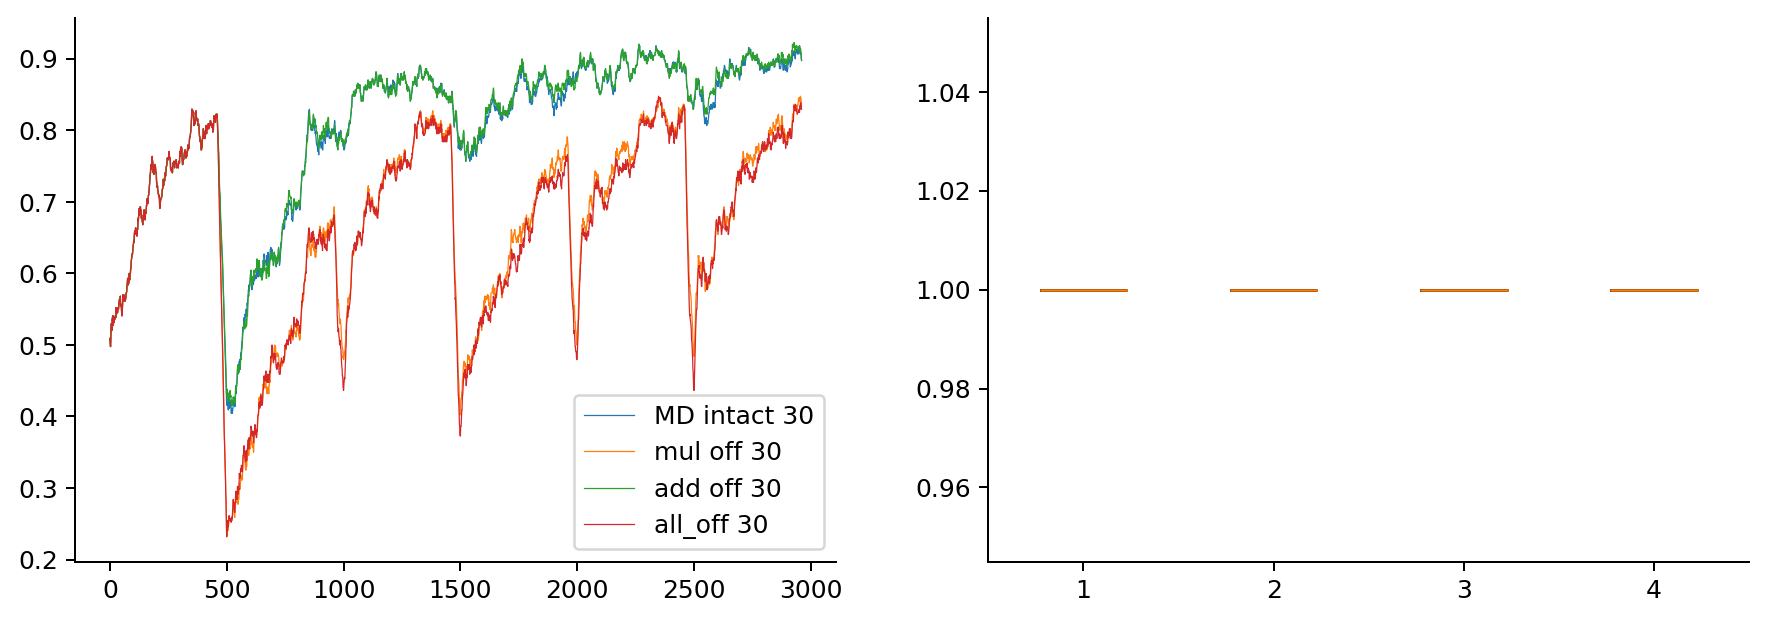

In [10]:
exp_name = 'controlled_md/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'mul off', 2:'add off', 3:'all_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
# vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
vars = [(var1, var2) for var1 in [0, 1,2, 3] for var2 in [30]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

fig, axes = plt.subplots(1,2 , figsize=[12,4])
ax = axes[0]
means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances, mods =[], []
        for log_file, config_file in zip (comp_files, conf_files):
            log = np.load(log_file, allow_pickle=True).item()
            if log.md_context_modulation > 0.8 : 
                performances.append(log.corrects)
                mods.append(log.md_context_modulation)
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
        md_modulations.append(mods)
    else:
        print(f'no files found for {label}')
ax.legend()

ax = axes[1]
_=ax.boxplot(md_modulations)
# plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)

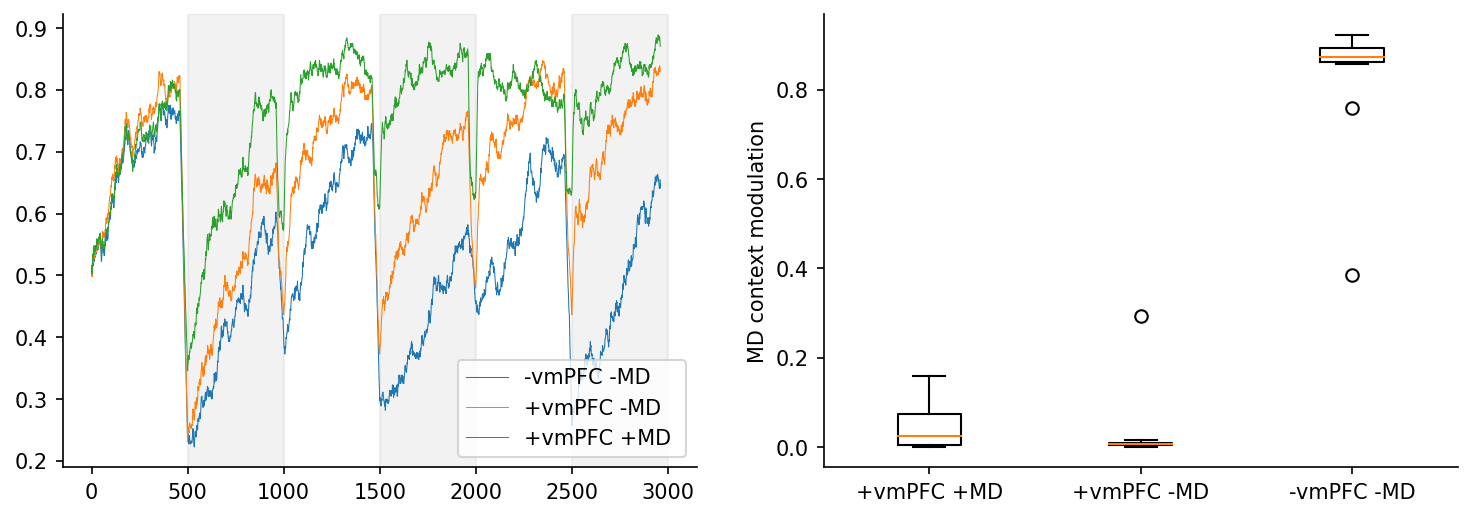

In [22]:
exp_name = 'vmPFC6/vmPFC_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: '+vmPFC +MD', 1: '+vmPFC -MD', 2:'-vmPFC -MD', 3:'all_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
# vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
vars = [(var1, var2) for var1 in [2 , 1, 0 ] for var2 in [30]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

fig, axes = plt.subplots(1,2 , figsize=[12,4])
ax = axes[0]
means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances, mods =[], []
        for log_file, config_file in zip (comp_files, conf_files):
            log = np.load(log_file, allow_pickle=True).item()
            # if log.md_context_modulation > 0.8 : 
            performances.append(log.corrects)
            mods.append(log.md_context_modulation)
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label[:-2], linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
        md_modulations.append(mods)
        
    else:
        print(f'no files found for {label}')
ax.legend()
tpb= 500
for ib in range(1, 6,2):
            ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')
ax = axes[1]
_=ax.boxplot(md_modulations)
ax.set_ylabel('MD context modulation')
ax.set_xticklabels(['+vmPFC +MD', '+vmPFC -MD', '-vmPFC -MD',])
plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)

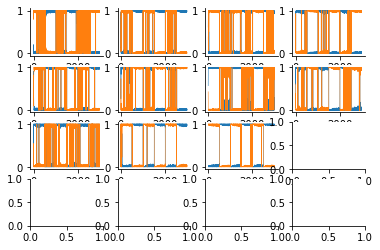

In [ ]:
i = 0
fig, axes = plt.subplots(4,4)
for log_file, config_file in zip (comp_files, conf_files):
    log = np.load(log_file, allow_pickle=True).item()
    axes.flatten()[i].plot(log.MDrates.mean(1), linewidth=0.5)
    i = i+ 1

In [ ]:
comp_files

[]

In [ ]:
md_modulations[0]


[0.024893333333333312,
 0.05565000000000001,
 0.011290000000000007,
 0.005096666666666678,
 0.007770000000000031,
 0.012589999999999987,
 0.2393933333333333,
 0.036683333333333325,
 0.0963266666666666,
 0.030156666666666727,
 0.878603333333335]

In [ ]:
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'mul off', 2:'add off', 3:'mul_off'}
vars = [(var1, var2) for var1 in [1] for var2 in [1 ]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]


In [ ]:
comp_files

[]

In [ ]:
log = np.load(comp_files[-1], allow_pickle=True).item()

In [ ]:
log.md_context_modulation

0.9068800000000036

In [ ]:
log.MDrates.shape

(3000, 200, 2)